In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("C://Users/matth/Downloads/310_23498_compressed_creditcard.csv/creditcard.csv")

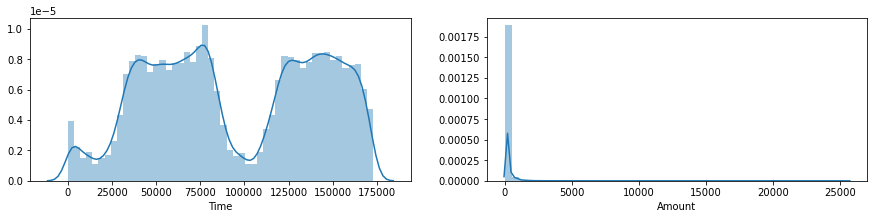

In [4]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.distplot(df.Time)
plt.subplot(1,2,2)
sns.distplot(df.Amount)

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler=RobustScaler()

df["scaled_time"]=scaler.fit_transform(df["Time"].values.reshape(-1,1))
df["scaled_amount"]=scaler.fit_transform(df["Amount"].values.reshape(-1,1))

In [6]:
df.drop(["Time","Amount"],axis=1,inplace=True)

In [7]:
new_df=df.sample(frac=1)
nfraud=len(new_df[new_df["Class"]==1])
clean_df=new_df[new_df["Class"]==0][:nfraud]
fraud_df=new_df[new_df["Class"]==1]
new_df=pd.concat([clean_df,fraud_df])
new_df = new_df.sample(frac=1, random_state=42)

Text(0.5, 1.0, 'Subsample Correlation Matrix')

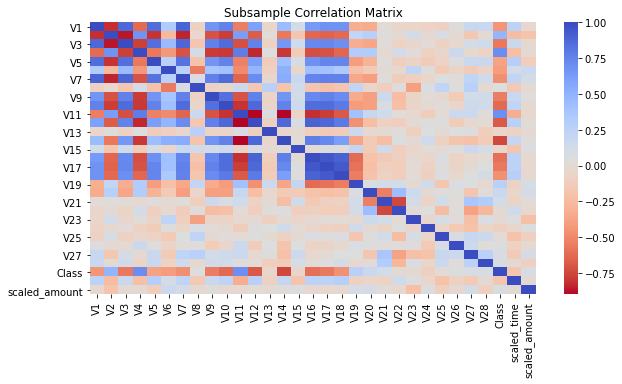

In [8]:
plt.figure(figsize=(10,5))
sns.heatmap(new_df.corr(),cmap="coolwarm_r")
plt.title("Subsample Correlation Matrix")

In [9]:
top_v=abs(new_df.corr()["Class"]).sort_values(ascending=False)[1:10].index

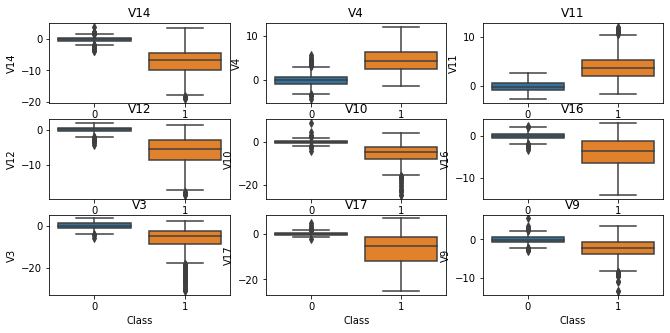

In [10]:
plt.figure(figsize=(11,5))
x=1
for col in top_v:
    plt.subplot(3,3,x)
    sns.boxplot(x="Class",y=col,data=new_df)
    plt.title(col)
    x=x+1

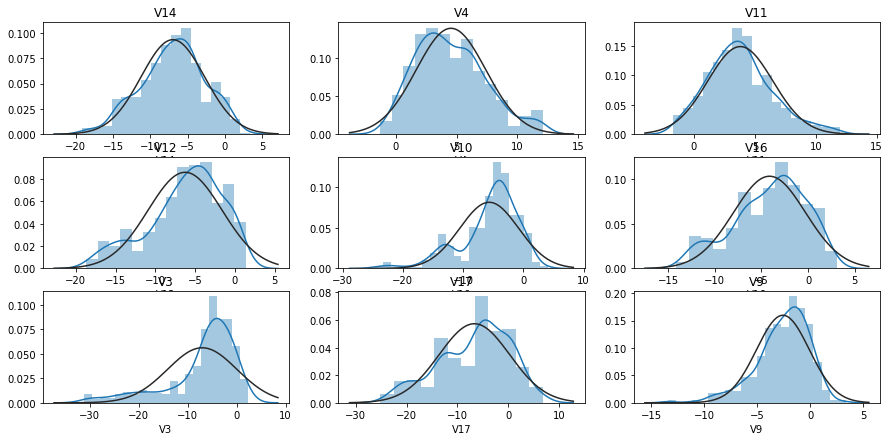

In [11]:
from scipy.stats import norm
plt.figure(figsize=(15,7))
x=1
for col in top_v:
    plt.subplot(3,3,x)
    sns.distplot(new_df[new_df["Class"]==1][col],fit=norm)  
    plt.title(col)
    x=x+1

In [12]:
#Removing outliers from fraud data.. not too sure why
fraud_df=new_df[new_df["Class"]==1]
outlier_df=pd.DataFrame(columns=new_df.columns)

for x in ["V14","V12","V10"]:
    IQR= (np.percentile(fraud_df[x],75)-np.percentile(fraud_df[x],25))*1.5
    lower_limit=np.percentile(fraud_df[x],25)-IQR
    upper_limit=np.percentile(fraud_df[x],75)+IQR
    outlier_df=outlier_df.append(fraud_df[(fraud_df[x]<=lower_limit) | (fraud_df[x]>=upper_limit)])
    #print(new_df[(new_df[x]<=lower_limit) | (new_df[x]>=upper_limit)].shape)
    #outlier_df=pd.concat([outlier_df,new_df[(new_df[x]<=lower_limit) & (new_df[x]<=upper_limit)]])
    

In [13]:
new_df.drop(outlier_df.drop_duplicates().index,inplace=True)

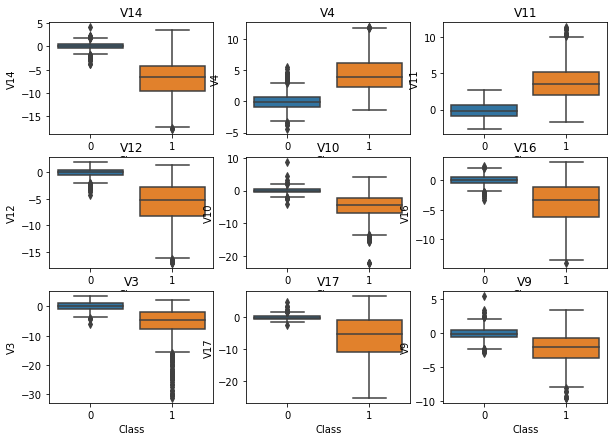

In [14]:
plt.figure(figsize=(10,7))
x=1
for col in top_v:
    plt.subplot(3,3,x)
    sns.boxplot(x="Class",y=col,data=new_df)
    plt.title(col)
    x=x+1

In [15]:
X=new_df.drop("Class",axis=1)
Y=new_df["Class"]
t0=time.time()
X_reduced_tsne=TSNE(n_components=2,random_state=42).fit_transform(X.values)
t1=time.time()
print("TSNE took {:.2}s".format(t1-t0))
t0=time.time()
X_reduced_pca=PCA(n_components=2,random_state=42).fit_transform(X)
t1=time.time()
print("PCA took {:.2}s".format(t1-t0))
t0=time.time()
X_reduced_SVD=TruncatedSVD(n_components=2,random_state=42,algorithm="randomized").fit_transform(X)
t1=time.time()
print("SVD took {:.2}s".format(t1-t0))

TSNE took 3.2s
PCA took 0.007s
SVD took 0.0045s


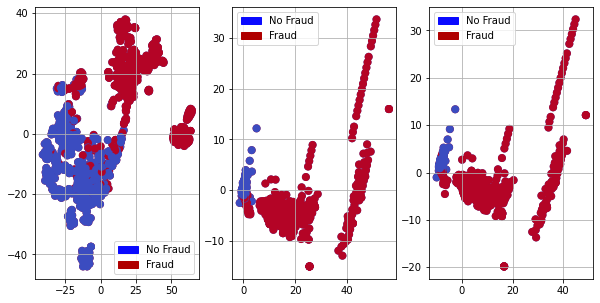

In [16]:
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
#sns.scatterplot(x=X_reduced_tsne[:,0],y=X_reduced_tsne[:,1],palette=(Y==0))
#sns.scatterplot(x=X_reduced_tsne[:,0],y=X_reduced_tsne[:,1],palette=(Y==1))
plt.scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1],c=(Y==0),cmap="coolwarm",label="No Fraud",linewidths=2)
plt.scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1],c=(Y==1),cmap="coolwarm",label="Fraud",linewidths=2)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])

plt.subplot(1,3,2)
plt.scatter(X_reduced_SVD[:,0],X_reduced_SVD[:,1],c=(Y==0),cmap="coolwarm",label="No Fraud",linewidths=2)
plt.scatter(X_reduced_SVD[:,0],X_reduced_SVD[:,1],c=(Y==1),cmap="coolwarm",label="Fraud",linewidths=2)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])

plt.subplot(1,3,3)
plt.scatter(X_reduced_pca[:,0],X_reduced_pca[:,1],c=(Y==0),cmap="coolwarm",label="No Fraud",linewidths=2)
plt.scatter(X_reduced_pca[:,0],X_reduced_pca[:,1],c=(Y==1),cmap="coolwarm",label="Fraud",linewidths=2)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])

In [17]:
X_reduced_tsne.shape

(961, 2)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key,classifier in classifiers.items():
    classifier.fit(X_train,Y_train)
    training_score=cross_val_score(classifier,X_train,Y_train,cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 90.0 % accuracy score


In [19]:
from sklearn.model_selection import GridSearchCV

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg=GridSearchCV(LogisticRegression(),log_reg_params)
grid_log_reg.fit(X_train,Y_train)
log_reg=grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, Y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, Y_train)

svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, Y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_


In [20]:
# Overfitting Case
log_reg_score = cross_val_score(log_reg, X_train, Y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, Y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, Y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, Y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  94.15%
Knears Neighbors Cross Validation Score 93.62%
Support Vector Classifier Cross Validation Score 94.28%
DecisionTree Classifier Cross Validation Score 93.62%


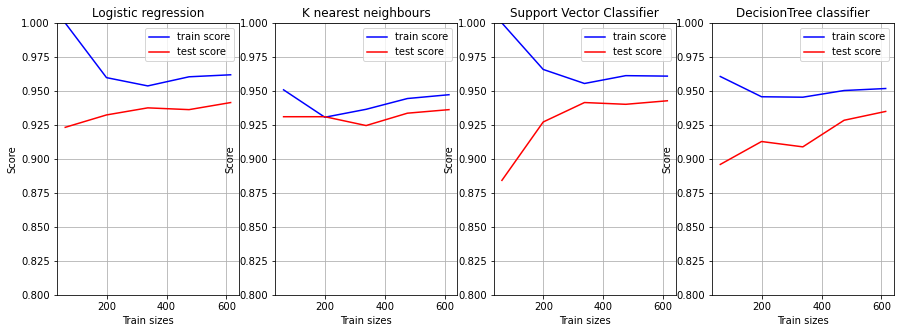

In [21]:
from sklearn.model_selection import learning_curve
models={"Logistic regression": log_reg,"K nearest neighbours": knears_neighbors,"Support Vector Classifier":
        svc,"DecisionTree classifier":tree_clf}
x=1
plt.figure(figsize=(15,5))
for key, model in models.items():
    train_sizes, train_scores, test_scores=learning_curve(model,X_train,Y_train)
    plt.subplot(1,4,x)
    plt.plot(train_sizes,train_scores.mean(axis=1),color="b",label="train score")
    plt.plot(train_sizes,test_scores.mean(axis=1),color="r",label="test score")
    plt.xlabel("Train sizes"),plt.ylabel("Score"),plt.grid(True),plt.legend(loc="best"),plt.ylim((0.8,1)),plt.title(key)

    x=x+1

(Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate'))

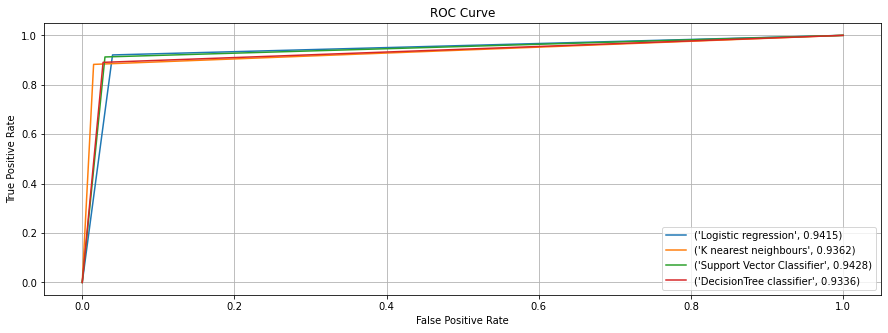

In [22]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(15,5))
for key, model in models.items():
    
    Y_predict=cross_val_predict(model,X_train,Y_train)
    fpr,tpr,thresholds=roc_curve(Y_train,Y_predict)
    plt.plot(fpr,tpr,label=(key,round(cross_val_score(model, X_train, Y_train).mean(),4)))
plt.legend(loc="best"),plt.grid(True), plt.title("ROC Curve")
plt.xlabel('False Positive Rate', fontsize=10), plt.ylabel('True Positive Rate', fontsize=10)
    

In [23]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
Y_ave=pd.DataFrame()

for key, model in models.items():
    Y_ave[key]=cross_val_predict(model,X_train,Y_train)
    print(f'{key} R2 is: ' + str(round(accuracy_score(Y_train,Y_ave[key]),3)))
Y_ave["Average"]=Y_ave.mean(axis=1)
Y_ave["predict"]=Y_ave["Average"].map(lambda x: 1 if x>=0.5 else 0)

print("R2 for averaged models is: ", str(round(accuracy_score(Y_train,Y_ave["predict"]),3)))

Logistic regression R2 is: 0.941
K nearest neighbours R2 is: 0.936
Support Vector Classifier R2 is: 0.943
DecisionTree classifier R2 is: 0.935
R2 for averaged models is:  0.943


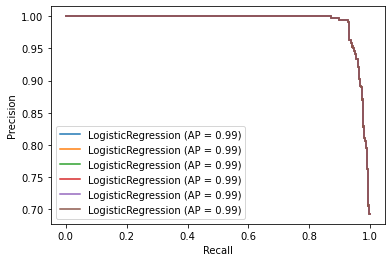

In [60]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
C=[0.01,0.1,1,10,100,1000]

fig,ax=plt.subplots()
for c in C:
    lr=LogisticRegression(class_weight={0:1,1:c})
    lr.fit(X_train,Y_train)
    pred_prob=log_reg.predict_proba(X_test)[:,1]
    precision_recall_curve(Y_test,pred_prob)
    plot_precision_recall_curve(log_reg,X_train,Y_train,response_method='predict_proba',ax=ax)

In [50]:
plot_precision_recall_curve?

In [26]:
undersample_X=df.drop("Class",axis=1)
undersample_Y=df["Class"]
for train_index, test_index in sss.split(undersample_X,undersample_Y):
    print("train_index is: ",train_index)
    print("test_index is: ",test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_Y.iloc[train_index], undersample_Y.iloc[test_index]
    
    undersample_accuracy = []
    undersample_precision = []
    undersample_recall = []
    undersample_f1 = []
    undersample_auc = []

NameError: name 'sss' is not defined

In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
roc_curve?